In [32]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

#Data Explore
from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *

#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix

from lifetimes.plotting import plot_probability_alive_matrix

from lifetimes.plotting import plot_period_transactions

from lifetimes.utils import calibration_and_holdout_data

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from lifetimes.plotting import plot_history_alive

from lifetimes import GammaGammaFitter




In [33]:
sales = pd.read_csv('../data/processed/sales.csv')
cols_of_interest = ['Date', 'Revenue', 'Customer']
df = sales[cols_of_interest]
df = df.rename({'Date':'Invoice Date'}, axis=1)
df

,Invoice Date,Revenue,Customer
0,2020-07-07,"$2,750",Nome Public Schools
1,2020-07-07,$495,Nome Public Schools
2,2020-07-07,$500,Nome Public Schools
3,2020-07-07,"$1,500",Nome Public Schools
4,2020-07-07,$500,Nome Public Schools
...,...,...,...
9541,2015-10-29,"$1,045",Northshore School District 417
9542,2015-10-29,$130,Northshore School District 417
9543,2015-07-28,$292,Northshore School District 417
9544,2015-02-26,$257,St. Joseph School


In [34]:
df['Invoice Date'].max()

'2020-12-31'

In [35]:
df['Customer'].nunique()

990

# CLV Model Definition¶
For the CLV models, the following nomenclature is used:

* **Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
* **T** represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

The following analysis is conducted in Python using Lifetimes packagedeveloped by Cameron Davidson-Pilon, data scientist at Shopify, and the code was largely borrowed from Lifetimes documentation.

https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=summary_data_from_transaction_data#lifetimes.utils.summary_data_from_transaction_data

In [38]:
data = summary_data_from_transaction_data(df, 'Customer', 'Invoice Date', monetary_value_col='Revenue', observation_period_end='2020-12-31')
data

,frequency,recency,T,monetary_value
Customer,,,,
ABSCO Alarms Inc.,$0,$0,"$1,428",$0
AGC Apprenticeship & Training,$0,$0,$177,$0
Aberdeen School District 5,$6,$411,"$2,185","$3,617"
Abraham Lincoln Elem School,$0,$0,"$1,311",$0
Abraham Lincoln Elementary School,$0,$0,"$1,583",$0
...,...,...,...,...
XIT Solutions,$13,$715,$990,"$3,850"
Yerington Elementary School,$7,"$1,711","$1,920","$12,006"
Yerington High School,$2,$28,"$1,907","$2,812"


In [41]:
pd.reset_option('all') 

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, ABSCO Alarms Inc. to Yvonne Shaw Middle School
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       990 non-null    float64
 1   recency         990 non-null    float64
 2   T               990 non-null    float64
 3   monetary_value  990 non-null    object 
dtypes: float64(3), object(1)
memory usage: 71.0+ KB


In [42]:
data.sort_values('monetary_value', ascending=False)

,frequency,recency,T,monetary_value
Customer,,,,
OETC,2.0,575.0,1122.0,300996.335000
Renton School District 403,13.0,1731.0,1768.0,241300.358462
Bellevue School District 405,6.0,1582.0,1646.0,118220.000000
Lynden Middle School,2.0,166.0,1113.0,105372.000000
Desert Skies Middle School,4.0,567.0,751.0,90990.612500
...,...,...,...,...
San Benito County Office of Education,1.0,98.0,2017.0,-868.000000
Jefferson Middle School,1.0,78.0,2180.0,-1531.000000
Raymond Elementary School,3.0,196.0,1613.0,-4000.733333


 frequency in days
 count    990.000000
mean       3.832323
std        8.624873
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max      111.000000
Name: frequency, dtype: float64
One time purchasers as a percent:  0.33535353535353535


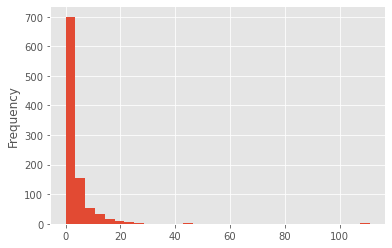

In [47]:
data['frequency'].plot(kind='hist', bins=31)
print(f' frequency in days\n', data['frequency'].describe()).format
print(f'One time purchasers as a percent: ', sum(data['frequency']==0)/float(len(data)))

In [61]:
freq_std = data['frequency'].std()
freq_std

8.62487324427689

In [63]:
most_freq = data.sort_values('frequency', ascending=False)
most_freq[most_freq['frequency']>freq_std]

,frequency,recency,T,monetary_value
Customer,,,,
Lake Washington School District 414,111.0,2093.0,2145.0,61281.932793
Mukilteo School District 6,110.0,2110.0,2173.0,35801.272727
Lakewood School District 306,94.0,2056.0,2185.0,10996.184787
Washoe County School District,80.0,2059.0,2173.0,13581.150000
Marysville School District 25,78.0,2150.0,2178.0,10922.629359
...,...,...,...,...
Redmond Elementary School,9.0,1491.0,1900.0,2831.833333
Roy H Gomm Elementary School,9.0,1336.0,2155.0,1135.743333
Northwest ESD 189,9.0,1441.0,1520.0,4892.388889


In [64]:
most_freq[most_freq['frequency']>freq_std].shape[0]/float(len(data))

0.11717171717171718

In [54]:
most_freq.head(25)

,frequency,recency,T,monetary_value
Customer,,,,
Lake Washington School District 414,111.0,2093.0,2145.0,61281.932793
Mukilteo School District 6,110.0,2110.0,2173.0,35801.272727
Lakewood School District 306,94.0,2056.0,2185.0,10996.184787
Washoe County School District,80.0,2059.0,2173.0,13581.150000
Marysville School District 25,78.0,2150.0,2178.0,10922.629359
Northshore School District 417,63.0,2067.0,2165.0,18995.893492
Antelope Valley High School District,57.0,2004.0,2004.0,83579.239825
Oxnard School District,45.0,2014.0,2185.0,19567.267778
National School District,43.0,1897.0,2185.0,29619.810000


# Frequency/Recency Analysis Using the BG/NBD Model

In [65]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 990 subjects, a: 1.15, alpha: 87.97, b: 5.21, r: 0.46>

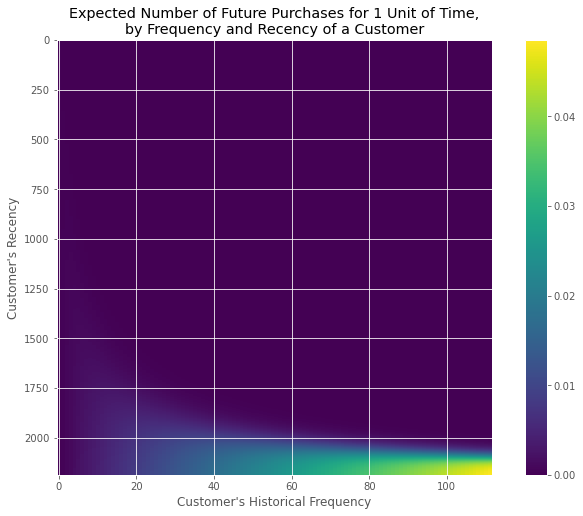

In [67]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf);

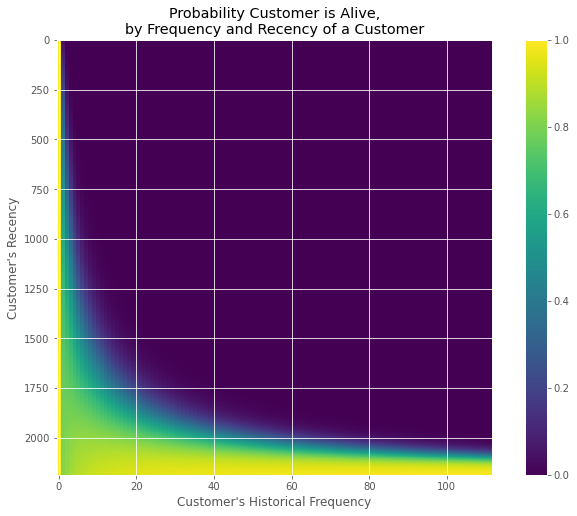

In [68]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

In [71]:
t = 1
data['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'],data['recency'], data['T'])

data.sort_values(by='predicted_purchase').tail(5)

,frequency,recency,T,monetary_value,predicted_purchase
Customer,,,,,
Anacortes School District 103,32.0,1198.0,1242.0,26809.860313,0.022292
Antelope Valley High School District,57.0,2004.0,2004.0,83579.239825,0.026954
Marysville School District 25,78.0,2150.0,2178.0,10922.629359,0.033381
Mukilteo School District 6,110.0,2110.0,2173.0,35801.272727,0.039784
Lake Washington School District 414,111.0,2093.0,2145.0,61281.932793,0.043868


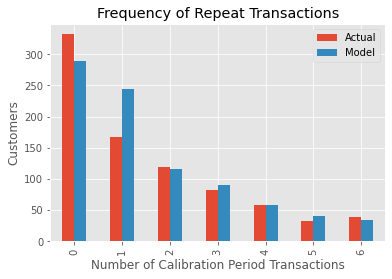

In [73]:
plot_period_transactions(bgf);

In [78]:
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer', 'Invoice Date', calibration_period_end = '2020-05-31', observation_period_end='2020-12-31')

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer,,,,,
ABSCO Alarms Inc.,0.0,0.0,1214.0,0.0,214.0
Aberdeen School District 5,6.0,411.0,1971.0,0.0,214.0
Abraham Lincoln Elem School,0.0,0.0,1097.0,0.0,214.0
Abraham Lincoln Elementary School,0.0,0.0,1369.0,0.0,214.0
Academy Of Arts Careers & Tech,8.0,1343.0,1858.0,0.0,214.0


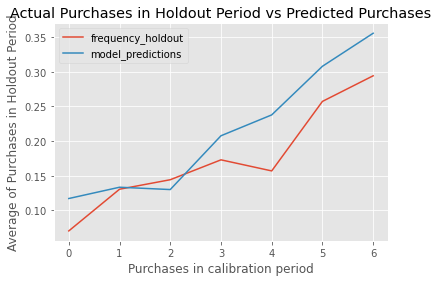

In [80]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);